In [7]:
import pydiffvg
import torch
import skimage
import skimage.io
import random
import ttools.modules
from tqdm import tqdm

In [10]:
"""
Scream: python painterly_rendering.py imgs/scream.jpg --num_paths 2048 --max_width 4.0
Fallingwater: python painterly_rendering.py imgs/fallingwater.jpg --num_paths 2048 --max_width 4.0
Fallingwater: python painterly_rendering.py imgs/fallingwater.jpg --num_paths 2048 --max_width 4.0 --use_lpips_loss
Baboon: python painterly_rendering.py imgs/baboon.png --num_paths 1024 --max_width 4.0 --num_iter 250
Baboon Lpips: python painterly_rendering.py imgs/baboon.png --num_paths 1024 --max_width 4.0 --num_iter 500 --use_lpips_loss
Kitty: python painterly_rendering.py imgs/kitty.jpg --num_paths 1024 --use_blob
"""

target = "./panda.png"
num_paths = 500
max_width = 2.0
use_lpips_loss = False
num_iter = 100
use_blob = True

pydiffvg.set_print_timing(False)

gamma = 1.0

# Use GPU if available
pydiffvg.set_use_gpu(torch.cuda.is_available())

perception_loss = ttools.modules.LPIPS().to(pydiffvg.get_device())

#target = torch.from_numpy(skimage.io.imread('imgs/lena.png')).to(torch.float32) / 255.0
target = skimage.io.imread(target)
target = torch.from_numpy(target).to(torch.float32) / 255.0
target = target.pow(gamma)
target = target.to(pydiffvg.get_device())
target = target.unsqueeze(0)
target = target.permute(0, 3, 1, 2) # NHWC -> NCHW
#target = torch.nn.functional.interpolate(target, size = [256, 256], mode = 'area')
canvas_width, canvas_height = target.shape[3], target.shape[2]
num_paths = num_paths
max_width = max_width

random.seed(1234)
torch.manual_seed(1234)

shapes = []
shape_groups = []
if use_blob:
    for i in range(num_paths):
        num_segments = random.randint(3, 5)
        num_control_points = torch.zeros(num_segments, dtype = torch.int32) + 2
        points = []
        p0 = (random.random(), random.random())
        points.append(p0)
        for j in range(num_segments):
            radius = 0.05
            p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
            p2 = (p1[0] + radius * (random.random() - 0.5), p1[1] + radius * (random.random() - 0.5))
            p3 = (p2[0] + radius * (random.random() - 0.5), p2[1] + radius * (random.random() - 0.5))
            points.append(p1)
            points.append(p2)
            if j < num_segments - 1:
                points.append(p3)
                p0 = p3
        points = torch.tensor(points)
        points[:, 0] *= canvas_width
        points[:, 1] *= canvas_height
        path = pydiffvg.Path(num_control_points = num_control_points,
                                points = points,
                                stroke_width = torch.tensor(1.0),
                                is_closed = True)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),
                                            fill_color = torch.tensor([random.random(),
                                                                    random.random(),
                                                                    random.random(),
                                                                    random.random()]))
        shape_groups.append(path_group)
else:
    for i in range(num_paths):
        num_segments = random.randint(1, 3)
        num_control_points = torch.zeros(num_segments, dtype = torch.int32) + 2
        points = []
        p0 = (random.random(), random.random())
        points.append(p0)
        for j in range(num_segments):
            radius = 0.05
            p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
            p2 = (p1[0] + radius * (random.random() - 0.5), p1[1] + radius * (random.random() - 0.5))
            p3 = (p2[0] + radius * (random.random() - 0.5), p2[1] + radius * (random.random() - 0.5))
            points.append(p1)
            points.append(p2)
            points.append(p3)
            p0 = p3
        points = torch.tensor(points)
        points[:, 0] *= canvas_width
        points[:, 1] *= canvas_height
        #points = torch.rand(3 * num_segments + 1, 2) * min(canvas_width, canvas_height)
        path = pydiffvg.Path(num_control_points = num_control_points,
                                points = points,
                                stroke_width = torch.tensor(1.0),
                                is_closed = False)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),
                                            fill_color = None,
                                            stroke_color = torch.tensor([random.random(),
                                                                        random.random(),
                                                                        random.random(),
                                                                        random.random()]))
        shape_groups.append(path_group)

scene_args = pydiffvg.RenderFunction.serialize_scene(\
    canvas_width, canvas_height, shapes, shape_groups)

render = pydiffvg.RenderFunction.apply
img = render(canvas_width, # width
                canvas_height, # height
                2,   # num_samples_x
                2,   # num_samples_y
                0,   # seed
                None,
                *scene_args)
pydiffvg.imwrite(img.cpu(), './init.png', gamma=gamma)

points_vars = []
stroke_width_vars = []
color_vars = []
for path in shapes:
    path.points.requires_grad = True
    points_vars.append(path.points)
if not use_blob:
    for path in shapes:
        path.stroke_width.requires_grad = True
        stroke_width_vars.append(path.stroke_width)
if use_blob:
    for group in shape_groups:
        group.fill_color.requires_grad = True
        color_vars.append(group.fill_color)
else:
    for group in shape_groups:
        group.stroke_color.requires_grad = True
        color_vars.append(group.stroke_color)

# Optimize
points_optim = torch.optim.Adam(points_vars, lr=1.0)
if len(stroke_width_vars) > 0:
    width_optim = torch.optim.Adam(stroke_width_vars, lr=0.1)
color_optim = torch.optim.Adam(color_vars, lr=0.01)

# Adam iterations.
for t in tqdm(range(num_iter)):
    # print('iteration:', t)
    points_optim.zero_grad()
    if len(stroke_width_vars) > 0:
        width_optim.zero_grad()
    color_optim.zero_grad()
    # Forward pass: render the image.
    scene_args = pydiffvg.RenderFunction.serialize_scene(canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                    canvas_height, # height
                    2,   # num_samples_x
                    2,   # num_samples_y
                    t,   # seed
                    None,
                    *scene_args)
    # Compose img with white background
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
    # Save the intermediate render.
    # pydiffvg.imwrite(img.cpu(), 'results/iter_{}.png'.format(t), gamma=gamma)
    img = img[:, :, :3]
    # Convert img from HWC to NCHW
    img = img.unsqueeze(0)
    img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
    if use_lpips_loss:
        loss = perception_loss(img, target) + (img.mean() - target.mean()).pow(2)
    else:
        loss = (img - target).pow(2).mean()
    # print('render loss:', loss.item())

    # Backpropagate the gradients.
    loss.backward()

    # Take a gradient descent step.
    points_optim.step()
    if len(stroke_width_vars) > 0:
        width_optim.step()
    color_optim.step()
    if len(stroke_width_vars) > 0:
        for path in shapes:
            path.stroke_width.data.clamp_(1.0, max_width)
    if use_blob:
        for group in shape_groups:
            group.fill_color.data.clamp_(0.0, 1.0)
    else:
        for group in shape_groups:
            group.stroke_color.data.clamp_(0.0, 1.0)

    # if t % 10 == 0 or t == num_iter - 1:
    #     pydiffvg.save_svg('results/painterly_rendering/iter_{}.svg'.format(t), canvas_width, canvas_height, shapes, shape_groups)

img = render(canvas_width, # width
                canvas_height, # height
                2,   # num_samples_x
                2,   # num_samples_y
                0,   # seed
                None,
                *scene_args)
# Compose img with white background
img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
# Save the intermediate render.
pydiffvg.imwrite(img.cpu(), './final.png'.format(t), gamma=gamma)

# pydiffvg.imwrite(img.cpu(), './final.png'.format(t), gamma=gamma)
# Render the final result.
# img = render(target.shape[1], # width
#                 target.shape[0], # height
#                 2,   # num_samples_x
#                 2,   # num_samples_y
#                 0,   # seed
#                 None,
#                 *scene_args)
# Save the intermediate render.
# pydiffvg.imwrite(img.cpu(), './final.png'.format(t), gamma=gamma)
# Convert the intermediate renderings to a video.
# from subprocess import call
# call(["ffmpeg", "-framerate", "24", "-i",
#     "results/painterly_rendering/iter_%d.png", "-vb", "20M",
#     "results/painterly_rendering/out.mp4"])

LPIPS is untested
100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


In [1]:
import torch
import diffusers
from diffusers import StableDiffusionPipeline

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(device)

cuda


In [2]:
model = "CompVis/stable-diffusion-v1-4"
pipeline = StableDiffusionPipeline.from_pretrained(model, torch_dtype=torch.float32).to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


  0%|          | 0/50 [00:00<?, ?it/s]

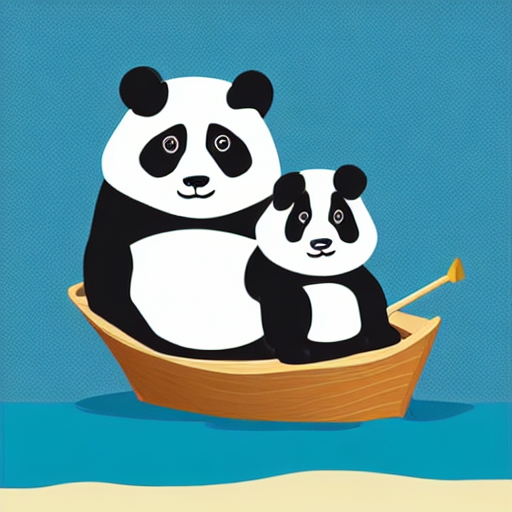

In [5]:
prompt = "a panda rowing a boat"
caption = " minimal flat 2d vector icon"
prompt = caption + prompt
image = pipeline(prompt).images[0] 
image 

In [6]:
image.save("./panda.png")